In [1]:
import skrub
from sklearn.ensemble import HistGradientBoostingClassifier
from skrub import TableVectorizer

import sempipes

dataset = skrub.datasets.fetch_midwest_survey()
X = dataset.X.head(n=500)
y = dataset.y.head(n=500)

responses = skrub.var("response", X)
responses = responses.skb.set_description(dataset.metadata["description"])

labels = skrub.var("labels", y)
labels = labels.skb.set_name(dataset.metadata["target"])

responses = responses.skb.mark_as_X()
labels = labels.skb.mark_as_y()

responses_with_additional_features = responses.with_sem_features(
    nl_prompt="""
        Compute additional demographics-related features, use your intrinsic knowledge about the US. 
        Take into account how the identification with the country or regions of it changed over the generations.         
        Also think about how the identification differs per class and education. The midwest is generally associated 
        with "Midwestern values" — friendliness, modesty, hard work, and community-mindedness.
    """,
    name="demographic_features",
    how_many=5,
)

feature_encoder = TableVectorizer()
encoded_responses = responses_with_additional_features.skb.apply(feature_encoder)

learner = HistGradientBoostingClassifier()
model = encoded_responses.skb.apply(learner, y=labels)

	> Querying 'openai/gpt-4.1' with 2 messages...'
	> Computed 5 new feature columns: ['Age_Group_Generation', 'Education_Level_Num', 'Income_Bracket_Num', 'Is_Midwest_Resident', 'Midwest_Identification_Score'], removed 0 feature columns: []


In [2]:
model

<Apply HistGradientBoostingClassifier>
Result:
―――――――
          Census_Region
0    West South Central
1    East North Central
2    East North Central
3    East North Central
4    East North Central
..                  ...
495            Mountain
496      South Atlantic
497     Middle Atlantic
498  West North Central
499  East North Central

[500 rows x 1 columns]

In [3]:
from sempipes.optimisers import optimise_olopro
from sempipes.optimisers.search_policy import TreeSearch

sempipes.set_config(
    sempipes.Config(
        llm_for_code_generation=sempipes.LLM(
            name="gemini/gemini-2.5-flash",
            parameters={"temperature": 0.3},
        ),
        llm_for_batch_processing=sempipes.LLM(
            name="ollama/gemma3:1b",
            parameters={"api_base": "http://localhost:11434", "temperature": 0.0},
        ),
    )
)

# Note that this should be done on a separate validation set in a real world use case
outcomes = optimise_olopro(
    model, "demographic_features", budget=12, scoring="accuracy", cv=5, search=TreeSearch(min_num_drafts=2)
)

	OLOPRO> Computing pipeline summary for context-aware optimisation ---
	TREE_SEARCH> Creating root node
	OLOPRO> Processing trial 0
	OLOPRO> Fitting pipeline
	OLOPRO> Evaluating pipeline via 5-fold cross-validation
	OLOPRO> Score changed to 0.756
	TREE_SEARCH> Drafting new node
	OLOPRO> Processing trial 1
	OLOPRO> Fitting pipeline
	> Querying 'gemini/gemini-2.5-flash' with 4 messages...'
	> An error occurred in attempt 1: Cannot convert non-finite values (NA or inf) to integer
	> Querying 'gemini/gemini-2.5-flash' with 6 messages...'
	> An error occurred in attempt 2: invalid literal for int() with base 10: 'N'
	> Querying 'gemini/gemini-2.5-flash' with 8 messages...'
	> Computed 11 new feature columns: ['Age_Education_Interaction', 'Age_Group_Numeric', 'Education_Level_Numeric', 'Household_Income_Numeric', 'Income_Midwest_Identification_Interaction', 'Is_Self_Identified_Midwest_Resident', 'Midwest_Identification_Strength', 'Midwest_Perception_Ratio', 'Midwest_State_Count', 'Non_Midwes

<string>:229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   2.   4.5  3.   5.   5.   2.   3.5  0.   6.   2.   0.   4.5  6.
 0.   6.   5.25 0.   3.   2.5  8.25 2.25 6.   2.75 0.   0.   0.   4.5
 4.5  0.   0.   5.   2.   4.5  2.25 1.25 7.5  4.5  5.25 0.   1.   6.75
 1.75 4.   8.25 0.   3.5  3.   4.   8.25 7.5  4.   0.   0.   0.   5.25
 2.5  0.75 7.5  0.   5.   2.5  0.   0.   9.   0.   9.   0.   5.   0.
 0.   0.   0.75 1.   0.25 0.   0.   0.   6.   0.   5.25 1.5  0.   8.25
 0.   0.75 2.75 0.   0.   0.   3.   3.   4.5  0.   9.   0.   0.   0.
 2.   5.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
<string>:228: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   2.   4.5  3.   5.   5.   2.   3.5  0.   6.   2.   0.   4.5  6.
 0.   6.   5.25 0.   3.   2.5  8.25 2.25 6.   2.75 0.  

	> Computed 26 new feature columns: ['Age_Education_Interaction', 'Age_Group_Midwest_State_Count_Interaction', 'Age_Group_Numeric', 'Age_Midwest_Identification_Interaction', 'Education_Income_Interaction', 'Education_Level_Numeric', 'Education_Midwest_Identification_Interaction', 'Gender_Encoded', 'Gender_Midwest_Identification_Interaction', 'Great_Lakes_Midwest_Count', 'Household_Income_Numeric', 'Income_Midwest_Identification_Interaction', 'Is_Self_Identified_Midwest_Resident', 'Midwest_Identification_Consistency_Score', 'Midwest_Identification_Mismatch_Score', 'Midwest_Identification_Strength', 'Midwest_Perception_Ratio', 'Midwest_Self_ID_State_Agreement_Score', 'Midwest_State_Count', 'Non_Midwest_State_Count', 'Normalized_Current_Region_Encoded', 'Perceived_Midwest_Breadth', 'Plains_Midwest_Count', 'Zip_Code_Midwest_Likelihood', 'Zip_First_Digit_Region', 'Zip_First_Two_Digits'], removed 0 feature columns: []
	OLOPRO> Evaluating pipeline via 5-fold cross-validation


<string>:228: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.   0.   4.5  0.   0.   0.   2.   5.   3.   1.5  2.25 9.   4.5
 2.5  2.25 1.5  3.5  4.5  6.75 3.   6.75 6.   3.5  5.25 6.   5.25 1.75
 4.5  3.5  3.   0.   2.25 0.   0.   4.5  4.5  4.   6.   3.   0.25 4.5
 0.   2.5  5.25 5.   6.   4.   6.   4.5  5.5  4.   5.   2.5  6.   3.
 0.   2.5  5.5  3.5  4.5  7.5  0.   3.5  4.5  0.   7.5  6.75 3.5  3.
 2.25 5.5  0.   6.75 0.   0.25 0.   2.25 0.   0.   0.5  2.5  9.   0.
 4.5  4.5  0.   0.5  3.   0.   0.   9.   0.   0.   0.   0.   0.   4.
 4.   5.   0.   1.5  0.   0.   3.   6.   5.25 3.   7.5  4.5  0.   4.
 2.5  3.75 3.   3.75 0.   9.   2.5  3.   8.25 0.   0.   0.   7.5  0.
 0.   0.   3.5  2.5  0.   0.   0.   0.75 4.   3.   9.   6.   1.5  5.25
 0.   9.   4.5  1.25 2.5  0.   6.75 1.75 9.   1.5  3.75 0.   5.25 6.75
 0.5  7.5  5.25 0.   6.   6.   7.5  0.   0.   0.   4.5  0.75 3.75 1.25
 3.   0.   0.   0. 

	OLOPRO> Score changed to 0.9280000000000002
	TREE_SEARCH> Trying to improve node with score 0.9299999999999999
	OLOPRO> Processing trial 10
	OLOPRO> Fitting pipeline
	> Querying 'gemini/gemini-2.5-flash' with 10 messages...'
	> Computed 26 new feature columns: ['Age_Education_Interaction', 'Age_Group_Numeric', 'Age_Midwest_Identification_Interaction', 'Age_Midwest_State_Count_Interaction', 'Education_Income_Interaction', 'Education_Level_Numeric', 'Education_Midwest_Identification_Interaction', 'Gender_Encoded', 'Gender_Midwest_Identification_Interaction', 'Great_Lakes_Midwest_Count', 'Household_Income_Numeric', 'Income_Midwest_Identification_Interaction', 'Is_Midwest_Zip_Code', 'Is_Self_Identified_Midwest_Resident', 'Midwest_Core_vs_Fringe_Perception_Difference', 'Midwest_Identification_Mismatch_Score', 'Midwest_Identification_Strength', 'Midwest_Perception_Ratio', 'Midwest_Self_ID_State_Agreement_Score', 'Midwest_State_Count', 'Non_Midwest_State_Count', 'Normalized_Current_Region_En

In [7]:
best_outcome = max(outcomes, key=lambda x: x.score)
best_outcome.score

0.93

In [8]:
print("\n".join(best_outcome.state["generated_code"]))


import numpy as np
import pandas as pd

# (Age_Group_Numeric)
# Usefulness: Converts categorical age ranges into an ordinal numerical scale. This allows the model to capture generational trends and how identification with regions might change across different age groups, directly addressing the prompt's requirement to consider generational changes.
# Input samples: 'Age': ['18-29', '18-29', '18-29']
df.loc[:, 'Age_Group_Numeric'] = df['Age'].map({
    '18-29': 1,
    '30-44': 2,
    '45-60': 3,
    '60+': 4
}).fillna(-1).astype(np.int8) # Fill NaN with -1 for unknown age groups

# (Education_Level_Numeric)
# Usefulness: Transforms educational attainment into an ordinal numerical scale. This helps the model understand how education levels might correlate with regional identity and perceptions, as requested by the prompt to consider differences per education level.
# Input samples: 'Education': ['High school degree', 'Associate or bachelor degree', 'Graduate degree']
df.loc[:, 'Educatio

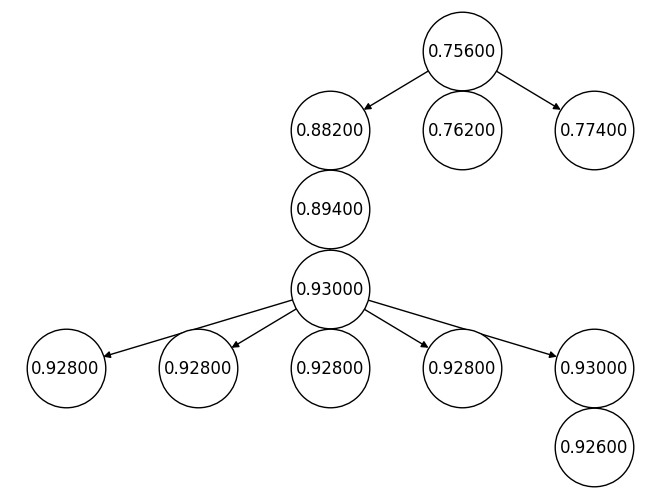

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

attributes = {}
edges = []

for outcome in outcomes:
    node_id = id(outcome.search_node)
    if outcome.search_node.parent is not None:
        parent_node_id = id(outcome.search_node.parent)
        edges.append((parent_node_id, node_id))
    attributes[node_id] = {"score": f"{outcome.score:.5f}"}

G = nx.DiGraph()
G.add_edges_from(edges)
nx.set_node_attributes(G, attributes)

labels = nx.get_node_attributes(G, "score")
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")

nx.draw(
    G,
    pos,
    with_labels=True,
    labels=labels,
    arrows=True,
    node_size=3200,
    node_color="white",
    edgecolors="black",
)
plt.show()